In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pydot
import pydotplus
import graphviz
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of uniform distribution of predecessors

In [3]:
step = 50
size = 10000
n = step * size
width = np.ceil(np.log2(n)).astype(int)
predecessors = np.arange(0, n, step)
predecessors = np.array([
    (predecessors[i]) for i in range(size)
]).astype(int)
predecessors, predecessors.shape, n

(array([     0,     50,    100, ..., 499850, 499900, 499950]),
 (10000,),
 500000)

In [4]:
cumulative_predecessors = np.array([(((i / size))) for i in range(size)])

cumulative_predecessors, cumulative_predecessors.size

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.997e-01, 9.998e-01,
        9.999e-01]), 10000)

## Bit conversion in digits of predecessors

In [5]:
predecessors = np.array([
    list(np.binary_repr(i, width)) for i in np.arange(0, n, step)
]).astype(int)
np.set_printoptions(threshold=100)
predecessors, predecessors.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]]), (10000, 19))

## Create training + testing set

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    predecessors, 
    cumulative_predecessors, 
    test_size=0.25, 
    random_state=42)

In [7]:
x_train.shape, y_train.shape

((7500, 19), (7500,))

In [8]:
x_test.shape, y_test.shape

((2500, 19), (2500,))

## Network Metrics

In [9]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.figure(figsize=(80,40))

## Defining custom sigmoid function

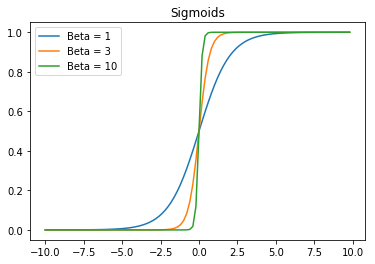

<Figure size 4320x2880 with 0 Axes>

In [10]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

beta005 = 0.05
beta02 = 0.2
beta05 = 0.5
beta1 = 1
beta3 = 3
beta10 = 10

def custom_activation(x):
    return (K.sigmoid(x * 3))

def custom_activation_plottable(x, beta):
    return (1 / (1 + np.exp(-x * beta)))

def range_sigmoid_plot(ran, beta):
    a = []
    for item in ran:
        a.append(custom_activation_plottable(item, beta))
    return a

x = np.arange(-10, 10, 0.2)
sig1 = range_sigmoid_plot(x, beta1)
sig3 = range_sigmoid_plot(x, beta3)
sig10 = range_sigmoid_plot(x, beta10)
sig05 = range_sigmoid_plot(x, beta05)
sig02 = range_sigmoid_plot(x, beta02)
sig005 = range_sigmoid_plot(x, beta005)

plt.title("Sigmoids")
plt.plot(x, sig1, label="Beta = 1")
plt.plot(x, sig3, label="Beta = 3")
plt.plot(x, sig10, label="Beta = 10")
plt.legend(loc='upper left')

plt.figure(figsize=(60,40))
plt.show() 

## Define function to build the model

In [11]:
from keras import metrics, optimizers

sgd = optimizers.SGD(lr=0.015)

def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(int(neurons * 3), input_dim=neurons, name="Input_dense_layer", activation=custom_activation))
    model.add(BatchNormalization())
    model.add(Dense(int(neurons * 2), name="Dense_layer_2", activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer", activation="sigmoid"))
    model.compile(
        loss='mean_squared_error', 
        optimizer=sgd, 
        metrics=['mean_absolute_error'])

    return model

## Construction of the model

In [12]:
from keras.utils import plot_model

model = build_model(width)
model.summary()
plot_model(model, to_file="net_model.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 57)                1140      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57)                228       
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 38)                2204      
_________________________________________________________________
batch_normalization_2 (Batch (None, 38)                152       
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 39        
Total params: 3,763
Trainable params: 3,573
Non-trainable params: 190
_________________________________________________________________


In [13]:
history = model.fit(
    x_train, 
    y_train,
    epochs=400,
    shuffle=True,
    batch_size=256,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)

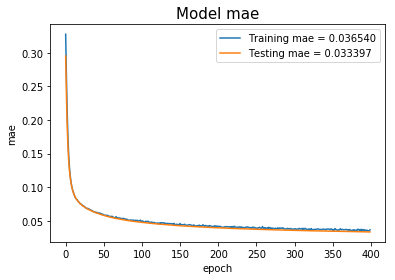

<Figure size 5760x2880 with 0 Axes>

In [14]:
%matplotlib inline
plot_history_graph(history, 'mean_absolute_error', 'mae')

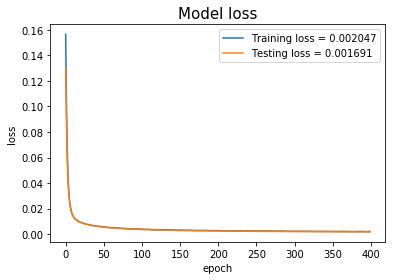

<Figure size 5760x2880 with 0 Axes>

In [15]:
plot_history_graph(history, 'loss', 'loss')

In [16]:
def prediction(num, width, model, size):
    bin = np.array([list(np.binary_repr(num, width))])
    print("Prediction on ", num, ":\t ", model.predict(bin))
    return np.floor(model.predict(bin) * size)

(prediction(int(86), width, model, size)), (prediction(int(n), width, model, size))

Prediction on  86 :	  [[0.04326243]]
Prediction on  500000 :	  [[0.9406199]]


(array([[432.]], dtype=float32), array([[9406.]], dtype=float32))

Prediction on  0 :	  [[0.06260297]]
Prediction on  0 :	  [[0.06260297]]
Calculated:		 [626.]
Prediction on  1 :	  [[0.0188766]]
Prediction on  1 :	  [[0.0188766]]
Calculated:		 [188.]
Prediction on  2 :	  [[0.088562]]
Prediction on  2 :	  [[0.088562]]
Calculated:		 [885.]
Prediction on  3 :	  [[0.02885466]]
Prediction on  3 :	  [[0.02885466]]
Calculated:		 [288.]
Prediction on  4 :	  [[0.05549555]]
Prediction on  4 :	  [[0.05549555]]
Calculated:		 [554.]
Prediction on  5 :	  [[0.02161219]]
Prediction on  5 :	  [[0.02161219]]
Calculated:		 [216.]
Prediction on  6 :	  [[0.07486576]]
Prediction on  6 :	  [[0.07486576]]
Calculated:		 [748.]
Prediction on  7 :	  [[0.03429868]]
Prediction on  7 :	  [[0.03429868]]
Calculated:		 [342.]
Prediction on  8 :	  [[0.04945135]]
Prediction on  8 :	  [[0.04945135]]
Calculated:		 [494.]
Prediction on  9 :	  [[0.01320693]]
Prediction on  9 :	  [[0.01320693]]
Calculated:		 [132.]
Prediction on  10 :	  [[0.06190768]]
Prediction on  10 :	  [[0.06190768]]
Ca

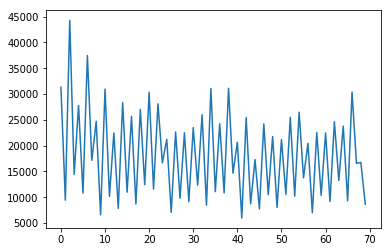

In [17]:
lst = []
for x in range(70):
    lst.append((prediction(x, width, model, n)[0]))
    print("Calculated:\t\t", prediction(x, width, model, size)[0])

plt.plot(lst)
plt.show()

In [18]:
#NOTA:
#FARSI UN LOG CON TUTTI GLI ESPERIMENTI PERCHÈ SARANNO MATERIALE DI TESI

#Specificare funzione di attivazione custom sigmoide con beta fissato
#Sigmoide = 1 / (1 + e ^ -beta * x)
#Derivata di sigmoide = beta
#Asintoti = 0, 1
#Beta elevato = slope più ripido
#Per beta diversi fare grafici diversi
#Guardare se con tali beta le predizioni migliorano

#Potrebbe essere che beta fosse troppo basso rendendo incapace la rete di raggiungere 0 ed 1

#Partire con beta minori di 1 e beta maggiori 1

#Modificare i learning rates
#Modificare neuroni hidden per farsi idea di "ottimale"


#NB: SE NULLA FUNZIONA PROVA QUA
#Se funziona male provare un primo strato nascosto con relu ed un secondo con sigmoide